# Tanpopo トラック ViT

In [1]:
!pip install transformers
!pip list | grep transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
transformers                  4.26.0


In [2]:
# Google Colab マウント
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
import os
os.chdir('/content/drive/MyDrive/Tanpopo')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [3]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torch.utils.data as data

In [4]:
#画像サイズがが704x480 #88x60
img_size = 224

#class_names = ['1Pit', '2Carrot', '3Straight', '4Teardrop']

# 標準化
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [5]:
batch_size =  "16" #@param[8, 16, 32, 64, 128, 256]
batch_size = int(batch_size)

epochs = "15" #@param[8, 10, 15, 20, 22, 25, 27, 29, 30, 31, 32, 33, 35, 45, 60, 120]
epochs = int(epochs)

### 関数、クラスの定義

In [6]:
import random
from sklearn.model_selection import train_test_split
import glob
def make_filepath_list(folderpath, phase='train'):
    """
    ファイルのパスを格納したリストを返す
    """
    file_list = []
    test_file_list = []
    train_file_list = []
    valid_file_list = []
    class_names = []

    # .DS_Storeが最初に読み込まれる
    for index, top_dir in enumerate(sorted(os.listdir(folderpath))):
        # if top_dir != '.DS_Store':
        file_dir = os.path.join(folderpath, top_dir)

        # for sub_dir in enumerate(os.listdir(file_dir)):
            # if sub_dir != '.DS_Store':
        file_list = glob.glob(file_dir + '/*/*000.bmp')

        if top_dir != '.DS_Store' and top_dir != 'README.md':
            class_names.append(top_dir)

            if phase == 'test': # テストデータの場合
                test_file_list += [os.path.join(folderpath, top_dir, file).replace('\\', '/') for file in file_list]
                                                                        
            else:
                # 各クラス(フォルダ)ごとに8割を訓練データ、2割を検証データとする
                file_list = [os.path.join(folderpath, top_dir, file).replace('\\', '/') for file in file_list] # += にしない
                train_file, valid_file = train_test_split(file_list, train_size=0.8, test_size=0.2, random_state=0)
                train_file_list += train_file
                valid_file_list += valid_file

    if phase == 'test':
        return test_file_list, class_names

    return train_file_list, valid_file_list, class_names

In [7]:
import numpy as np
import torch
import torchvision.transforms as transforms

#mean = (0.5, 0.5, 0.5)
#std = (0.5, 0.5, 0.5)
mean = torch.tensor([0.5, 0.5, 0.5]).reshape(3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).reshape(3, 1, 1)

class ZCAWhiteningTransform(object):
    def __init__(self, mean, std, epsilon=1e-5):
        self.mean = torch.tensor(mean, dtype=torch.float32).view(1, -1)
        self.std = torch.tensor(std, dtype=torch.float32).view(1, -1)
        self.epsilon = epsilon

    def __call__(self, tensor):
        #flat_tensor = tensor.reshape(-1, tensor.shape[-1])
        flat_tensor = tensor.reshape(-1, 3)
        # subtract the mean
        centered_tensor = flat_tensor - self.mean
        # divide by the standard deviation
        normalized_tensor = centered_tensor / (self.std + self.epsilon)
        # calculate the ZCA matrix
        cov = np.cov(normalized_tensor, rowvar=False)
        U, S, V = np.linalg.svd(cov)
        ZCA_matrix = np.dot(U, np.dot(np.diag(1 / np.sqrt(S + self.epsilon)), U.T))
        # apply the ZCA matrix
        whitened_tensor = np.dot(normalized_tensor, ZCA_matrix)
        # reshape the tensor and return it
        return torch.tensor(whitened_tensor.reshape(*tensor.shape))


class ImageTransform(object):
    """
    画像の前処理
    """
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                # データオグメンテーション, 前処理
                transforms.Resize(256), # リサイズ
                transforms.CenterCrop(resize), # 切り取り
                transforms.RandomRotation(45), # ランタムに回転
                transforms.ColorJitter(), # ランダムに明るさ、コントラスト、彩度、色相を変化
                transforms.RandomHorizontalFlip(), # ランダムに左右(水平)反転
                transforms.RandomVerticalFlip(), # ランダムに上下(垂直)反転
                
                # # ガウス分布 に従ってカーネル内の重みを計算したフィルタ
                # transforms.GaussianBlur(5), # ガウシアンフィルタを適用する ########
                
                # # 写真撮影で過度の露出から起こる画像反転現象。
                # transforms.RandomSolarize(threshold=150),  # ランダムにソラリゼーションを行う 露出

                # #鮮鋭化とは、ぼやけた画像のエッジを際立たせる処理のことをいう。
                # transforms.RandomAdjustSharpness(sharpness_factor=3), # ランダムに鮮鋭化を行う

                # transforms.RandomAutocontrast(), # ランダムにコントラスト調整を行う

                # transforms.RandomEqualize(), # ランダムにヒストグラム平坦化を行う

                transforms.ToTensor(),
                transforms.RandomErasing(), # ランダムに選択した領域を除去する *ImageではなくTensorの変換
                #transforms.Normalize(mean, std), # zcaと交換？
                transforms.Lambda(ZCAWhiteningTransform(mean, std)), # ZCA whitening追加する
            ]),
            'valid': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [8]:
from torchvision.io import read_image
from PIL import Image

class SurfaceObjectDataset(data.Dataset):
    """
    表面付着物のDatasetクラス
    PyTorchのDatasetクラスを継承
    """
    def __init__(self, file_list, classes, transform=None, phase='train'):
        #super().__init__()
        self.file_list = file_list
        self.transform = transform
        self.classes = classes
        self.phase = phase

        #self.img = None
        #self.label = None

    def __len__(self):
        """
        画像の枚数を返す
        """
        return len(self.file_list)

    def __getitem__(self, index):
        """
        前処理した画像データのTensor形式のデータとラベルを取得
        """
        # 指定したindexの画像を読み込む
        img_path = self.file_list[index]
        img = Image.open(img_path)

        # 画像ラベルをファイル名から抜き出す
        label = self.file_list[index].split('/')[7][:11]

        # ラベル名を数値に変換
        label = self.classes.index(label)

        # 画像の前処理を実施
        if self.transform is not None:
            img_transformed = self.transform(img, self.phase)
            #img_transformed = feature_extractor(images=img_transformed, return_tensors="pt")

        return img_transformed, label

### データ読み込み・前処理

In [9]:
# 訓練、検証データへのファイルパスを格納したリストを取得
train_file_list, valid_file_list, class_names = make_filepath_list('/content/drive/MyDrive/Tanpopo/Track/TrainData', 'train')

print('train_file_list: ', train_file_list)
print('train num: ', len(train_file_list))
print('valid num: ', len(valid_file_list))
print('class_names: ', class_names)
class_num = len(class_names) # 5

train_each_class_num = dict()
for class_name in class_names:
    train_each_class_num[class_name] = 0

valid_each_class_num = dict()
for class_name in class_names:
    valid_each_class_num[class_name] = 0

for file in train_file_list: # train class num
    label = file.split('/')[7][:11]
    train_each_class_num[label] += 1

for file in valid_file_list: # validation class num
    label = file.split('/')[7][:11]
    valid_each_class_num[label] += 1

print('train_each_class_num: ', train_each_class_num)
print('valid_each_class_num: ', valid_each_class_num)


# Datasetの作成
train_dataset = SurfaceObjectDataset(
    file_list = train_file_list, classes = class_names,
    transform = ImageTransform(img_size, mean, std),
    phase = 'train'
)

valid_dataset = SurfaceObjectDataset(
    file_list = valid_file_list, classes = class_names,
    transform = ImageTransform(img_size, mean, std),
    phase = 'valid'
)

# Dataloaderの作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle=False
)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size = int(batch_size/2), shuffle=False
)

dataloaders_dict = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

# # イテレータに変換
# batch_iterator = iter(dataloaders_dict['train'])

# inputs, labels = next(batch_iterator)
# print('inputs size: ', inputs.size())

train_file_list:  ['/content/drive/MyDrive/Tanpopo/Track/TrainData/1Pit/SD1A0362T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/1Pit/SD1A0104T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/1Pit/SD1A0120T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/1Pit/EJ1A0115T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/1Pit/SF1A0623T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/1Pit/SF1A0514T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/2Carrot/NN1A0393T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/2Carrot/EJ1A0151T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/2Carrot/EL1A0307T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/2Carrot/SE1A0282T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/2Carrot/SE1A0016T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/2Carrot/NP1A0071T/000000.bmp', '/content/drive/MyDrive/Tanpopo/Track/TrainData/2Ca

<ipython-input-7-684e1a90be57>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean, dtype=torch.float32).view(1, -1)
<ipython-input-7-684e1a90be57>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std, dtype=torch.float32).view(1, -1)


### モデルの作成

In [10]:
from transformers import ViTFeatureExtractor, ViTModel
# ファインチューニングされたモデルをロードして使う場合はViTForImageClassificationですぐに分類問題に適用できるようですが、
# 今回はファインチューニングの実装のところからも行いたいので、こちらは使いません。
# from transformers import ViTForImageClassification

# 前処理用クラス
#feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k', return_tensors="pt")

# モデル本体
# 順伝播時の出力にAttentionの結果もほしいときはoutput_attentions=Trueを指定する。
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', output_attentions=True)

In [11]:
#print(vit_model)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ViTNet(nn.Module):
    def __init__(self, pretrained_vit_model, class_num):
        super(ViTNet, self).__init__()
        self.vit = pretrained_vit_model
        self.fc = nn.Linear(768, class_num) # 全結合層

    def _get_cls_vec(self, states): # 画像全体の特徴ベクトル
        return states['last_hidden_state'][:, 0, :]

    def forward(self, input_ids):
        states = self.vit(input_ids)
        states = self._get_cls_vec(states)
        states = self.fc(states)
        return states
    
model_ViT = ViTNet(vit_model, class_num)
model_ViT.to(device)

ViTNet(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias

In [13]:
from torch.optim import lr_scheduler

total_params = 0
trainable_params = 0

# まず全パラメータを勾配計算Falseにする
for param in model_ViT.parameters():
    param.requires_grad = False
    total_params += param.numel() # 全パラメータ数

# 追加したクラス分類用の全結合層を勾配計算ありに変更
for param in model_ViT.fc.parameters():
    param.requires_grad = True
    trainable_params += param.numel() # 訓練パラメータ数

optimizer = optim.AdamW(model_ViT.fc.parameters(), lr=0.1, weight_decay=0.9)

criterion = nn.CrossEntropyLoss()

# 7エポックごとに学習率を1/10ずつ減衰させます
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 100000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # 各エポックには訓練フェーズと検証フェーズがあります
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに設定します
            else:
                model.eval()   # モードを評価するモデルを設定します

            running_loss = 0.0
            running_corrects = 0

            # データをイレテートします
            for inputs, labels in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # パラメータの勾配をゼロにします
                optimizer.zero_grad()

                # 順伝播
                # 訓練の時だけ、履歴を保持します
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 訓練の時だけ逆伝播＋オプティマイズを行います
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 損失を計算します
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)

            print(' {} Loss: {:.4f} Acc: {:.4f} '.format(
                phase, epoch_loss, epoch_acc), end='\t')

            # モデルをディープ・コピー
            if phase == 'valid':
                if epoch_acc >= best_acc and epoch_loss <= best_loss:
                        best_acc = epoch_acc
                        best_loss = epoch_loss
                        best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Loss: {:4f}'.format(best_loss))

    # ベストモデルの重みをロード
    model.load_state_dict(best_model_wts)
    return model

### 学習・検証

In [15]:
PATH = '/content/drive/MyDrive/Tanpopo/Track/Single/model_ViT_weights.pth'
#model_ViT.load_state_dict(torch.load(PATH)) # 学習前: 前回の重みを使う

In [16]:
epochs = 64
print('ViT Training :')
print('-'*10)
model_ViT = model_ViT.to(device)
model_ViT = train_model(model_ViT, criterion, optimizer, scheduler, num_epochs=epochs) # 学習

ViT Training :
----------
Epoch 0/63
 train Loss: 9.3310 Acc: 0.1034 	 valid Loss: 1.5506 Acc: 0.2222 	
Epoch 1/63
 train Loss: 2.7829 Acc: 0.2414 	 valid Loss: 1.5826 Acc: 0.3333 	
Epoch 2/63
 train Loss: 3.9233 Acc: 0.3793 	 valid Loss: 1.9259 Acc: 0.3333 	
Epoch 3/63
 train Loss: 4.1867 Acc: 0.2759 	 valid Loss: 1.6813 Acc: 0.3333 	
Epoch 4/63
 train Loss: 3.5785 Acc: 0.1379 	 valid Loss: 1.4370 Acc: 0.3333 	
Epoch 5/63
 train Loss: 2.2194 Acc: 0.2069 	 valid Loss: 1.3396 Acc: 0.4444 	
Epoch 6/63
 train Loss: 1.1412 Acc: 0.5517 	 valid Loss: 1.3002 Acc: 0.5556 	
Epoch 7/63
 train Loss: 2.3726 Acc: 0.3793 	 valid Loss: 1.2996 Acc: 0.5556 	
Epoch 8/63
 train Loss: 2.2222 Acc: 0.4138 	 valid Loss: 1.3004 Acc: 0.5556 	
Epoch 9/63
 train Loss: 2.7570 Acc: 0.3103 	 valid Loss: 1.3074 Acc: 0.5556 	
Epoch 10/63
 train Loss: 1.7938 Acc: 0.3793 	 valid Loss: 1.3214 Acc: 0.5556 	
Epoch 11/63
 train Loss: 1.6831 Acc: 0.4483 	 valid Loss: 1.3352 Acc: 0.5556 	
Epoch 12/63
 train Loss: 1.3046 Acc:

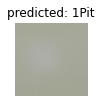

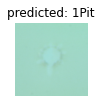

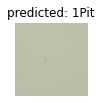

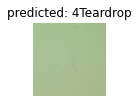

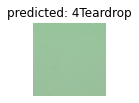

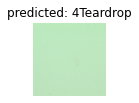

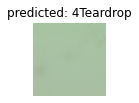

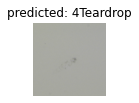

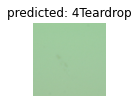

Track Validation
Vision Transformer network
class_names:  ['1Pit', '2Carrot', '3Straight', '4Teardrop']
[[2 0 0 0]
 [1 0 0 1]
 [0 0 0 2]
 [0 0 0 3]]

Accuracy :  [88.9 77.8 77.8 66.7]
Recall :  [66.7  nan  nan 50. ]
Precision :  [100.   0.   0. 100.]


<ipython-input-17-7913f3f41776>:14: RuntimeWarning: invalid value encountered in long_scalars
  return conf_mat[label][label] / np.sum(conf_mat[:, label])


In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np

#正解率
def class_accuracy(label, conf_mat):
    return (conf_mat[label][label] + (np.sum(conf_mat) - (np.sum(conf_mat[:, label])+np.sum(conf_mat[label])-conf_mat[label][label]))) / np.sum(conf_mat)
    
#精度(適合率)
def class_precision(label, conf_mat):
    return conf_mat[label][label] / np.sum(conf_mat[label])

#再現率
def class_recall(label, conf_mat):
    return conf_mat[label][label] / np.sum(conf_mat[:, label])

import matplotlib.pyplot as plt
def imshow(inp, title=None, mean=mean, std=std):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # プロット図が更新されるように少しだけ一時停止

model_ViT.eval()

labels_sum = None
predicted_sum = None

num_images = 4
model_ViT.eval()
#images_so_far = 0
fig = plt.figure()

mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

with torch.no_grad():
    model_ViT.eval()
    for data in dataloaders_dict['valid']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_ViT(images)

        #outputs = nn.Softmax(dim=1)(outputs)

        _, predicted = torch.max(outputs, 1)

        if labels_sum is None:
            labels_sum = labels
            predicted_sum = predicted
        else:
            labels_sum = torch.cat([labels_sum, labels], dim=0)
            predicted_sum = torch.cat([predicted_sum, predicted], dim=0)

        #print(images.size()[0])
        images_so_far = 0
        for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, 4, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predicted[j]]))
                imshow(images.cpu().data[j], mean=mean, std=std)

#混同行列
labels_sum = labels_sum.cpu()
predicted_sum = predicted_sum.cpu()
conf_mat = None
print('Track Validation')
print('Vision Transformer network')
print('class_names: ', class_names)

Accuracy = []
Precision = []
Recall = []

conf_mat = confusion_matrix(labels_sum, predicted_sum)
print(conf_mat)
print()
for i in range(class_num):
    Accuracy = np.append(Accuracy, class_accuracy(i, conf_mat)*100)
    Precision = np.append(Precision, class_precision(i, conf_mat)*100)
    Recall = np.append(Recall, class_recall(i, conf_mat)*100)

np.set_printoptions(precision=1)

print('Accuracy : ', Accuracy)
print('Recall : ', Recall)
print('Precision : ', Precision)

In [21]:
PATH = '/content/drive/MyDrive/Tanpopo/Track/Single/model_ViT_weights.pth'
#torch.save(model_ViT.state_dict(), PATH) # 重みを保存